In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
!pwd

/Users/Mark/fruitpunch/cv_practice/unsupervised_evaluation


In [4]:
! ls ../data

14007262601.jpg                  34006105201.jpg
14007262601_colour_corrected.jpg 34008200601.jpg
14007262601_labels.png           annotations_PAC_AUS.csv
34006089701.jpg


In [5]:
image_path = '/Users/Mark/fruitpunch/cv_practice/data/'
image_file = '14007262601.jpg'

In [6]:
bgr = cv2.imread(image_path + image_file)

lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)

lab_planes = cv2.split(lab)

# clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
clahe = cv2.createCLAHE()

lab_planes[0] = clahe.apply(lab_planes[0])

lab = cv2.merge(lab_planes)

bgr_col_corr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

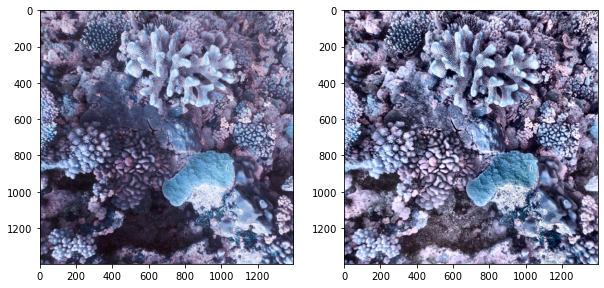

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(bgr);
ax[1].imshow(bgr_col_corr);

In [8]:
new_image = image_file.split('.')[0] + '_colour_corrected.' + image_file.split('.')[1]

In [9]:
plt.imsave(image_path + new_image, bgr_col_corr)
print("wrote: " + image_path + new_image)

wrote: /Users/Mark/fruitpunch/cv_practice/data/14007262601_colour_corrected.jpg


In [10]:
os.chdir("/Users/Mark/fruitpunch/cv_practice/pytorch-unsupervised-segmentation-tip")

!python demo.py --nChannel 10 --maxIter 10 --visualize 1 --input {image_path + new_image}

os.chdir("/Users/Mark/fruitpunch/cv_practice/unsupervised_evaluation")

/Users/Mark/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
0 / 10 |  label num : 10  | loss : 2.6963298320770264
1 / 10 |  label num : 10  | loss : 2.116821050643921
2 / 10 |  label num : 10  | loss : 1.8064266443252563
3 / 10 |  label num : 10  | loss : 1.6881096363067627
4 / 10 |  label num : 10  | loss : 1.6074494123458862
5 / 10 |  label num : 10  | loss : 1.532610297203064
6 / 10 |  label num : 9  | loss : 1.4385565519332886
7 / 10 |  label num : 9  | loss : 1.3248059749603271
8 / 10 |  label num : 8  | loss : 1.2015933990478516
9 / 10 |  label num : 7  | loss : 1.0829200744628906


In [11]:
!mv /Users/Mark/fruitpunch/cv_practice/pytorch-unsupervised-segmentation-tip/output.png /Users/Mark/fruitpunch/cv_practice/data/

In [12]:
image_labels = image_file.split('.')[0] + '_labels.png'

In [13]:
!mv /Users/Mark/fruitpunch/cv_practice/data/output.png {image_path + image_labels}

In [14]:
!ls ../data

14007262601.jpg                  34006105201.jpg
14007262601_colour_corrected.jpg 34008200601.jpg
14007262601_labels.png           annotations_PAC_AUS.csv
34006089701.jpg


In [15]:
annot_file = 'annotations_PAC_AUS.csv'

In [29]:
df = pd.read_csv(image_path + annot_file, index_col=0)

In [30]:
id = os.path.basename(image_file).rstrip('.jpg')
id = int(id)
df = df.loc[id]

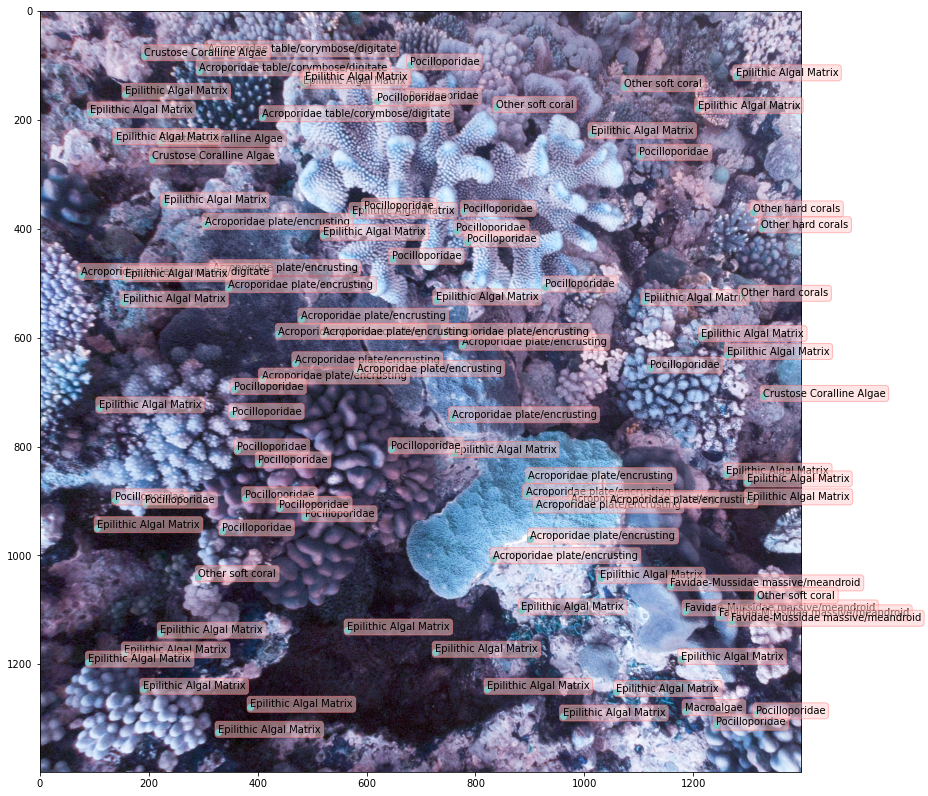

In [31]:
fig, ax = plt.subplots(1,1, figsize=(14,14))
ax.imshow(bgr);
ax.scatter(df["x"], df["y"], color="c");
for k, s in enumerate(df["label_name"]):
  x = df["x"].iloc[k]
  y = df["y"].iloc[k]
  plt.text(x, y, s, color='k', fontsize=10, 
           bbox=dict(boxstyle="round", 
                     ec=(1., 0.5, 0.5),
                     fc=(1., 0.8, 0.8),
                     alpha=0.5))

In [32]:
lbls = cv2.imread(image_path + image_labels, 0)

In [33]:
np.unique(lbls)

array([ 98, 112, 131, 147, 157, 159, 191], dtype=uint8)

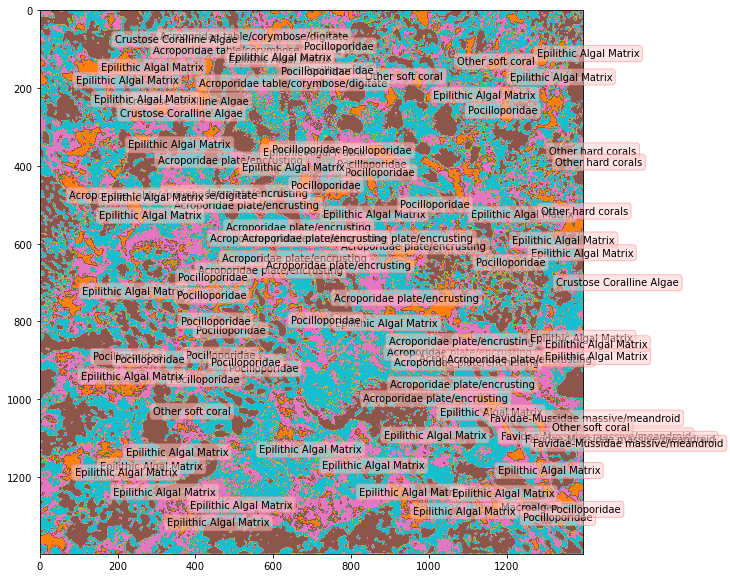

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(lbls, cmap=plt.get_cmap('tab10'))
for k,s in enumerate(df["label_name"]):
  x = df["x"].iloc[k]
  y = df["y"].iloc[k]
  plt.text(x, y, s, color='k', fontsize=10, 
           bbox=dict(boxstyle="round", 
                     ec=(1., 0.5, 0.5),
                     fc=(1., 0.8, 0.8),
                     alpha=0.5))

In [35]:
df['label_name'].unique()

array(['Acroporidae plate/encrusting',
       'Acroporidae table/corymbose/digitate', 'Crustose Coralline Algae',
       'Epilithic Algal Matrix', 'Favidae-Mussidae massive/meandroid',
       'Macroalgae', 'Other hard corals', 'Other soft coral',
       'Pocilloporidae'], dtype=object)

In [36]:
coral_coords = dict.fromkeys(df['label_name'].unique().tolist())

for lbl in df['label_name'].unique():
    ind = df['label_name'] == lbl
    coral_coords[lbl] = df.loc[ind,('x','y')].to_numpy()


In [37]:
df['category'] = int(0)

In [38]:
for label_name, coords in coral_coords.items():
    #print(label_name, '\n', coords)
    x = coords[:,0]
    y = coords[:,1]
    classes = lbls[x, y]
    
    ind = df['label_name'] == label_name
    df.loc[ind,'category'] = classes

In [102]:
data_to_plot = df.groupby(['label_name','category'], as_index=True)['category'].count()
data_to_plot

label_name                            category
Acroporidae plate/encrusting          147          6
                                      157          3
                                      159          1
                                      191          9
Acroporidae table/corymbose/digitate  157          1
                                      191          3
Crustose Coralline Algae              112          1
                                      147          2
                                      191          1
Epilithic Algal Matrix                112          2
                                      147          5
                                      157         12
                                      159          1
                                      191         17
Favidae-Mussidae massive/meandroid    112          1
                                      147          1
                                      191          2
Macroalgae                            112          1

In [103]:
data_to_plot = data_to_plot.reset_index(level=['label_name'])
data_to_plot.rename(columns={'category':'count'}, inplace=True)
data_to_plot['class'] = data_to_plot.index
data_to_plot.reset_index(inplace=True, drop=True)

In [107]:
data_to_plot.head()

,label_name,count,class
0,Acroporidae plate/encrusting,6,147
1,Acroporidae plate/encrusting,3,157
2,Acroporidae plate/encrusting,1,159
3,Acroporidae plate/encrusting,9,191
4,Acroporidae table/corymbose/digitate,1,157


In [121]:
coral_coords.keys()

dict_keys(['Acroporidae plate/encrusting', 'Acroporidae table/corymbose/digitate', 'Crustose Coralline Algae', 'Epilithic Algal Matrix', 'Favidae-Mussidae massive/meandroid', 'Macroalgae', 'Other hard corals', 'Other soft coral', 'Pocilloporidae'])

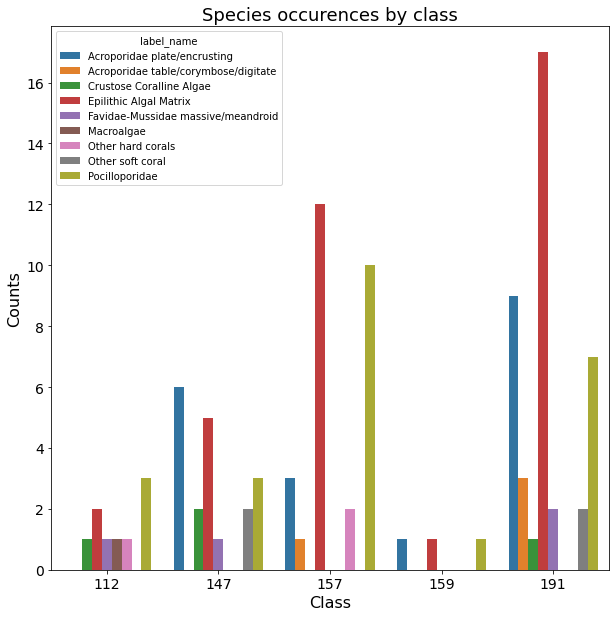

In [122]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.barplot(data=data_to_plot, x='class', y='count', hue='label_name', hue_order=list(coral_coords.keys()), ax=ax);
ax.set_title('Species occurences by class', size=18);
ax.set_ylabel('Counts',size=16);
ax.set_xlabel('Class', size=16);
ax.tick_params(labelsize=14);

In [152]:
np.unique(df['label_name'])

array(['Acroporidae plate/encrusting',
       'Acroporidae table/corymbose/digitate', 'Crustose Coralline Algae',
       'Epilithic Algal Matrix', 'Favidae-Mussidae massive/meandroid',
       'Macroalgae', 'Other hard corals', 'Other soft coral',
       'Pocilloporidae'], dtype=object)

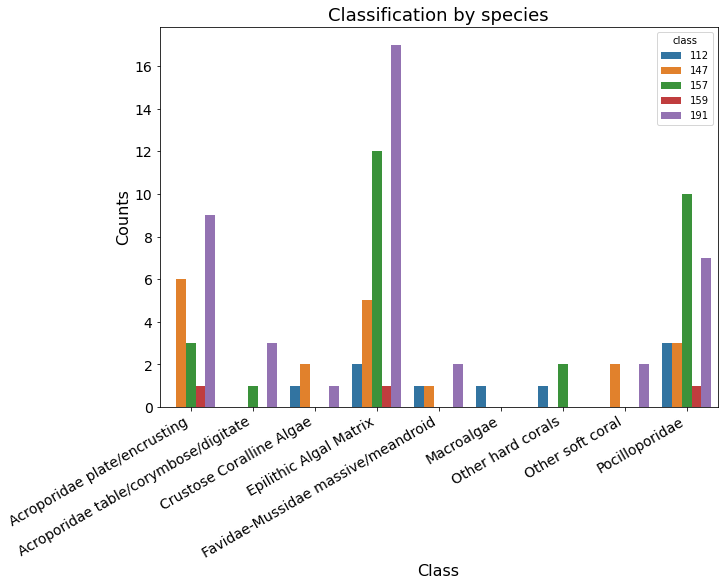

In [151]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.barplot(ax=ax, data=data_to_plot, x='label_name', y='count', hue='class', 
            hue_order=np.unique(data_to_plot['class']));
ax.set_title('Classification by species', size=18);
ax.set_ylabel('Counts',size=16);
ax.set_xlabel('Class', size=16);
ax.tick_params(labelsize=14);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right');

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(lbls, cmap=plt.get_cmap('tab10'))
ax.scatter(coral_coords['Pocilloporidae'][:,0], coral_coords['Pocilloporidae'][:,1],c='k')
for x, y in coral_coords['Pocilloporidae']:
    plt.text(x, y, 'Pocilloporidae', color='k', fontsize=10, 
             bbox=dict(boxstyle="round", 
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       alpha=0.5))